# First steps

In [522]:
# do a gridsearch
# palacge everything to delivare it as a project
# make it to the git
# make the code look sexy
# remove havily coralated features
# turn everything to Spacy from NLTK
# lemmatizations and other features that so not have
# word2vec vectoriztion instead of tfidf
# try to use classification when its possible and regression when it's not

In [523]:
#importing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
import nltk
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, f_regression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, KFold, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, make_scorer
from skll.metrics import kappa
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_selection import chi2
from sklearn.svm import SVC, LinearSVC
from tqdm import tqdm_notebook
from pathlib import Path
import warnings
words_english = set(nltk.corpus.words.words())
correct_words_set = set(nltk.corpus.brown.words())
lematizator = en_core_web_sm.load()
warnings.filterwarnings('ignore')
plt.style.use('seaborn-colorblind')
%matplotlib inline

In [524]:
RANDOM_STATE = 47
essays = pd.read_excel('/home/michael/Desktop/thesiswork/data/training_set_rel3.xlsx')
essays = essays[['essay_set','essay', 'domain1_score']].dropna()

In [525]:
essays.head()

,essay_set,essay,domain1_score
0,1,"Dear local newspaper, I think effects computer...",8.0
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0
4,1,"Dear @LOCATION1, I know having computers has a...",8.0


In [526]:
essays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12977 entries, 0 to 12977
Data columns (total 3 columns):
essay_set        12977 non-null int64
essay            12977 non-null object
domain1_score    12977 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 405.5+ KB


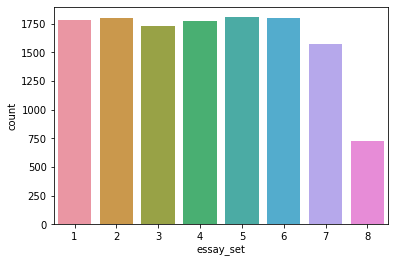

In [527]:
sns.countplot(essays['essay_set'])

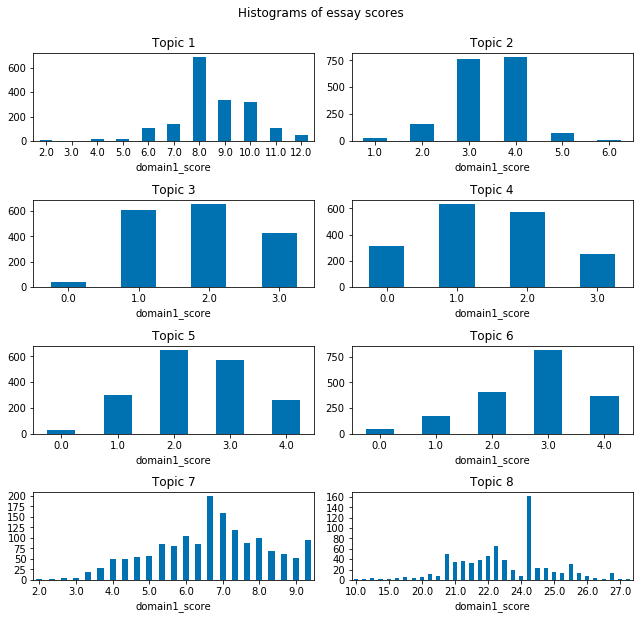

In [528]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        essays[essays['essay_set'] == topic_number]\
            .groupby('domain1_score')['essay_set'].agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Feature Engineering

In [529]:
essays = essays[(essays['essay_set']==3)]
essays['essay'] = essays['essay'].apply(lambda x : x.lower())
essays.reset_index(drop=True,inplace=True)

In [530]:
nltk_sentences_tokinized = []
for i in tqdm_notebook(essays['essay']):
    nltk_sentences_tokinized += [nltk.sent_tokenize(i)]
essays['essay_sentences'] = nltk_sentences_tokinized
essays['sentences_count'] = essays["essay_sentences"].apply(lambda x:len(x))

In [531]:
nltk_words_tokinized = []
for i in tqdm_notebook(essays['essay']):
    nltk_words_tokinized += [[word for word in nltk.word_tokenize(i) if word not in punctuation]]
essays['essay_words'] = nltk_words_tokinized
essays['words_count'] = essays['essay_words'].apply(lambda x:len(x))

In [532]:
def words_filter(essays):
    punctuation_count = []
    misspelled_words_count = []
    for essay in tqdm_notebook(essays):
        pc_temp=0
        mw_temp=0
        for word in nltk.word_tokenize(essay):
            if word.lower() not in punctuation:
                if word.lower() not in correct_words_set:
                    mw_temp+=1
            else:
                pc_temp+=1
        punctuation_count.append(pc_temp)
        misspelled_words_count.append(mw_temp)
    return punctuation_count,misspelled_words_count
word_features = words_filter(essays['essay'])
essays['punctuatioon_count'] = word_features[0]
essays['spelling_errors'] = word_features[1]
essays['character_count'] = essays['essay'].apply(lambda essay:len(essay))
essays['words_per_sent_ratio'] = round(essays['words_count']/essays['sentences_count'])
essays['avg_sen_len'] = round(essays['character_count']/essays['sentences_count'])

In [533]:
english_words=[]
for listofwords in tqdm_notebook(essays['essay_words']):
    temp_english_word=0
    for word in listofwords:
        if word in words_english:
            temp_english_word+=1
    english_words.append(temp_english_word)
essays['english_words']=english_words

In [534]:
nltk_words_tokinized_no_stop_words = []
stopwords_count = []
for tolinized_list in tqdm_notebook(essays['essay_words']):
    temp_stop_words_count = 0
    temp_nsw = []
    for word in tolinized_list:
        if word not in STOP_WORDS:
            temp_nsw.append(word)
        else:
            temp_stop_words_count+=1
    nltk_words_tokinized_no_stop_words.append(temp_nsw)
    stopwords_count.append(temp_stop_words_count)
essays['essay_words'] = nltk_words_tokinized_no_stop_words
essays['stopwords_count'] = stopwords_count

In [535]:
list_of_all_tags=['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS']

In [536]:
def words_joiner(essays):
    for line_number in tqdm_notebook(range(essays.index[0],essays.index[-1]+1)):
        essays['essay_words'][line_number] = ' '.join(essays['essay_words'][line_number])

In [537]:
for i in list_of_all_tags:
    essays[i] = 0
for line_number in tqdm_notebook(range(essays.index[0],essays.index[-1]+1)):
    temp_pos_list = np.unique(np.array(nltk.pos_tag(essays['essay_words'][line_number]))[:,1], return_counts=True)
    pos_list = list(zip(temp_pos_list[0],temp_pos_list[1]))
    for i in pos_list:
        essays[i[0]][line_number]=i[1]
essays.drop(columns=["''", '--', ':', '(', ')', '.', ',', '``', '$','essay','essay_sentences'],inplace=True,axis=1)
words_joiner(essays)

In [538]:
lemmatized_essay_words = []
for essay in  tqdm_notebook(essays['essay_words']):
    lemmatized = [t.lemma_ for t in lematizator(essay)]
    lemmatized_essay_words.append(lemmatized)
essays['essay_words'] = lemmatized_essay_words
essays['token_count'] = essays['essay_words'].apply(lambda x: len(x))
essays['unique_token_count'] = essays['essay_words'].apply(lambda x: len(set(x)))
words_joiner(essays)

In [539]:
essays

,essay_set,domain1_score,sentences_count,essay_words,words_count,punctuatioon_count,spelling_errors,character_count,words_per_sent_ratio,avg_sen_len,...,WRB,NNP,EX,NNS,SYM,CC,CD,POS,token_count,unique_token_count
0,3,1.0,3,feature set affect cyclist way feature set aff...,51,3,1,264,17.0,88.0,...,0,0,0,3,0,0,0,0,18,13
1,3,2.0,12,feature set affect cyclist negative way desert...,191,35,28,1016,16.0,85.0,...,0,3,0,7,0,0,0,0,87,61
2,3,1.0,8,travel unfamiliar place lose ask local directi...,100,10,5,512,12.0,64.0,...,0,2,0,12,0,0,0,0,49,36
3,3,1.0,3,believe feature cyclist affect impatient trust...,88,5,12,433,29.0,144.0,...,0,1,0,5,0,0,0,0,41,39
4,3,2.0,3,set effect cyclist set diffrent story sense se...,143,6,21,701,48.0,234.0,...,0,3,0,7,0,0,0,0,65,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,3,2.0,6,story set affect cyclist way example condition...,68,12,2,354,11.0,59.0,...,0,0,0,3,0,0,0,0,36,31
1722,3,1.0,3,feature set affect cyclist like goup hill long...,55,6,4,294,18.0,98.0,...,0,1,0,4,0,0,0,0,30,28
1723,3,2.0,5,set greatly affect cyclist try yosemite nation...,117,12,15,599,23.0,120.0,...,0,3,0,3,0,0,0,0,53,43
1724,3,2.0,7,feature set affect cyclist author say californ...,156,20,11,828,22.0,118.0,...,0,2,0,11,0,0,0,0,69,49


# Modeling

In [540]:
tv = TfidfVectorizer(ngram_range=(1, 5), max_features=50000)
essay_words_vectorized = tv.fit_transform(essays['essay_words'])
y_train = essays['domain1_score']

In [541]:
# text_dim = 300
# print("Training Word2Vec model...")
# wordvec_model = Word2Vec(essays['essay_words'].values, size=text_dim, window=5, min_count=3, workers=4, sg=1)
# print("Word2Vec model created.")
# print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))
# wordvec_model.save('wordvec_model')
# print("Word2Vec model saved.")

In [542]:
reg = LinearRegression()
clf = LogisticRegression(C=2.089999999999999,n_jobs=-1,random_state = RANDOM_STATE,max_iter=5000)
svmka = LinearSVC(random_state = RANDOM_STATE)
tree = RandomForestClassifier(random_state = RANDOM_STATE)
catclf=CatBoostClassifier(n_estimators=500,random_state = RANDOM_STATE)
catregr = CatBoostRegressor(n_estimators=1000,random_state = RANDOM_STATE)
NBC=MultinomialNB()

In [543]:
#sel_varience = VarianceThreshold(threshold=(.9 * (1 - .9)))
sel_k_best = SelectKBest(chi2, k=15)
#selected_sel_varience = sel_varience.fit_transform(essays.drop(['domain1_score','essay_words','essay_set'],axis=1))
selected_sel_k_best = sel_k_best.fit_transform(essays.drop(['domain1_score','essay_words','essay_set'],axis=1),y_train)

In [544]:
scaleer = StandardScaler(copy=True, with_mean=True, with_std=True)

In [545]:
train = scaleer.fit_transform(selected_sel_k_best)

In [546]:
X = hstack([essay_words_vectorized,train])

In [547]:
print(X.get_shape)

<bound method spmatrix.get_shape of <1726x50015 sparse matrix of type '<class 'numpy.float64'>'
	with 205454 stored elements in COOrdinate format>>


In [548]:
pca = TruncatedSVD(n_components=50,random_state = RANDOM_STATE)

In [549]:
X_reduced = pca.fit_transform(X)

In [550]:
print(pca.explained_variance_ratio_.sum())

0.9453929118416055


In [ ]:
kappa_scorer = make_scorer(kappa)
splits = KFold(n_splits=5,random_state = RANDOM_STATE)
model = clf
cv_scores_kappa_scorer = cross_val_score(model, X_reduced, essays['domain1_score'], cv=splits, scoring=kappa_scorer, n_jobs=-1, verbose=True)
cv_scores_accuracy = cross_val_score(model, X_reduced, essays['domain1_score'], cv=splits, scoring='accuracy', n_jobs=-1, verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
print(cv_scores_accuracy.mean(),cv_scores_kappa_scorer.mean())

In [ ]:
#Best score
# 0.6854134204574013, 0.5246124981953143

In [ ]:
print(cv_scores_accuracy)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
X = essays[essays.drop(['domain1_score','essay_words','essay_set'],axis=1).columns[(sel_k_best.get_support())]]
y = y_train.astype(np.float64)


forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=26)

forest.fit(X, y)

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# plot feature importances

features = pd.DataFrame({'feature_name': X.columns, 'importance': forest.feature_importances_, 'std': std})
features.sort_values('importance')\
        .plot.barh(x='feature_name', y='importance', xerr='std', legend=False)
plt.title('Gini importances of forest features')
plt.xlabel('Gini-importance')
plt.tight_layout()
plt.show()